In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout
%matplotlib inline
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history

Using TensorFlow backend.
C:\home\anaconda\envs\TF\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
path = os.getcwd()
print(path)

C:\home\program


In [3]:
os.chdir('../')

# data

In [4]:
oosaka = pd.read_csv('program/Stock2/stock2-oosaka.csv', encoding="shift_jis")
oosaka['day'] = pd.to_datetime(oosaka['day'], format='%Y/%m/%d')
tokyo = pd.read_csv('program/Stock2/stock2-tokyo.csv', encoding="shift_jis")
tokyo['day'] = pd.to_datetime(tokyo['day'], format='%Y/%m/%d')
aichi = pd.read_csv('program/Stock2/stock2-aichi.csv', encoding="shift_jis")
aichi['day'] = pd.to_datetime(aichi['day'], format='%Y/%m/%d')
saitama = pd.read_csv('program/Stock2/stock2-saitama.csv', encoding="shift_jis")
saitama['day'] = pd.to_datetime(saitama['day'], format='%Y/%m/%d')
hukuoka = pd.read_csv('program/Stock2/stock2-hukuoka.csv', encoding="shift_jis")
hukuoka['day'] = pd.to_datetime(hukuoka['day'], format='%Y/%m/%d')

In [5]:
def ema(milktea, period):
    ema = np.zeros(len(milktea))
    ema[:] = np.nan # NaN で一旦初期化
    ema[period-1] = milktea[:period].mean() # 最初だけ単純移動平均で算出
    
    for day in range(period, len(milktea)):
        ema[day] = ema[day-1] + (milktea[day] - ema[day-1]) / (period + 1) * 2
    
    return ema

In [6]:
oosaka.set_index('day')
dateTimeIndex = pd.DatetimeIndex(oosaka['day'])
oosaka.index = dateTimeIndex

In [7]:
tokyo.set_index('day')
dateTimeIndex = pd.DatetimeIndex(tokyo['day'])
tokyo.index = dateTimeIndex

In [8]:
aichi.set_index('day')
dateTimeIndex = pd.DatetimeIndex(aichi['day'])
aichi.index = dateTimeIndex

In [9]:
saitama.set_index('day')
dateTimeIndex = pd.DatetimeIndex(saitama['day'])
saitama.index = dateTimeIndex

In [10]:
hukuoka.set_index('day')
dateTimeIndex = pd.DatetimeIndex(hukuoka['day'])
hukuoka.index = dateTimeIndex

In [11]:
TimeIndex = pd.date_range("2019-10-02", periods=367, freq="D")
TimeIndex2 = pd.date_range("2020-01-15", periods=262, freq="D")

In [12]:
oosaka = oosaka.resample('D').interpolate()
tokyo = tokyo.resample('D').interpolate()
aichi = aichi.resample('D').interpolate()
saitama = saitama.resample('D').interpolate()
hukuoka = hukuoka.resample('D').interpolate()

In [13]:
oosaka.drop("day", axis=1)
tokyo.drop("day", axis=1)
aichi.drop("day", axis=1)
saitama.drop("day", axis=1)
hukuoka.drop("day", axis=1)

,start,hight,low,end
day,,,,
2019-10-02,2043.000000,2068.000000,2018.000000,2064.000000
2019-10-03,2004.000000,2028.000000,1983.000000,2026.000000
2019-10-04,1976.000000,1998.000000,1969.000000,1986.000000
2019-10-05,1980.333333,2000.333333,1966.333333,1983.333333
2019-10-06,1984.666667,2002.666667,1963.666667,1980.666667
...,...,...,...,...
2020-09-28,1885.000000,1919.000000,1878.000000,1919.000000
2020-09-29,1903.000000,1905.000000,1854.000000,1876.000000
2020-09-30,1842.000000,1845.000000,1764.000000,1764.000000


In [14]:
S_tokyo = tokyo['end'].astype(int)
S_oosaka = oosaka['end'].astype(int)
S_aichi = aichi['end'].astype(int)
S_saitama = saitama['end'].astype(int)
S_hukuoka = hukuoka['end'].astype(int)

In [15]:
S_tokyo["指数移動平均(30)"]=pd.Series(ema(S_tokyo, 30).round(1))
S_oosaka["指数移動平均(30)"]=pd.Series(ema(S_oosaka, 30).round(1))
S_aichi["指数移動平均(30)"]=pd.Series(ema(S_aichi, 30).round(1))
S_saitama["指数移動平均(30)"]=pd.Series(ema(S_saitama, 30).round(1))
S_hukuoka["指数移動平均(30)"]=pd.Series(ema(S_hukuoka, 30).round(1))

# 大阪

In [16]:
L = len(oosaka)
Y = oosaka.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [17]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [18]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [19]:
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [20]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [21]:
len(X)

364

In [22]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [23]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.9443 - mean_absolute_error: 0.9705
Epoch 2/50
 - 0s - loss: 0.8736 - mean_absolute_error: 0.9334
Epoch 3/50
 - 0s - loss: 0.8248 - mean_absolute_error: 0.9070
Epoch 4/50
 - 0s - loss: 0.7831 - mean_absolute_error: 0.8838
Epoch 5/50
 - 0s - loss: 0.7445 - mean_absolute_error: 0.8616
Epoch 6/50
 - 0s - loss: 0.7080 - mean_absolute_error: 0.8402
Epoch 7/50
 - 0s - loss: 0.6730 - mean_absolute_error: 0.8191
Epoch 8/50
 - 0s - loss: 0.6392 - mean_absolute_error: 0.7982
Epoch 9/50
 - 0s - loss: 0.6062 - mean_absolute_error: 0.7773
Epoch 10/50
 - 0s - loss: 0.5737 - mean_absolute_error: 0.7562
Epoch 11/50
 - 0s - loss: 0.5420 - mean_absolute_error: 0.7350
Epoch 12/50
 - 0s - loss: 0.5113 - mean_absolute_error: 0.7138
Epoch 13/50
 - 0s - loss: 0.4814 - mean_absolute_error: 0.6926
Epoch 14/50
 - 0s - loss: 0.4517 - mean_absolute_error: 0.6708
Epoch 15/50
 - 0s - loss: 0.4226 - mean_absolute_error: 0.6488
Epoch 16/50
 - 0s - loss: 0.3948 - mean_absolute_error: 0.6270
E

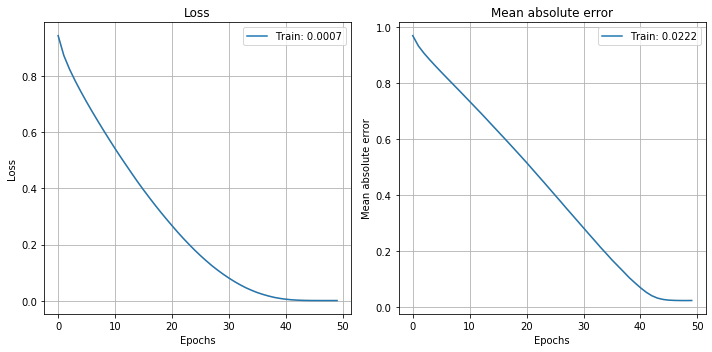

In [24]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_oosaka = model.predict(X_test)

In [25]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(oosaka.iloc[3:105,0])

In [26]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(oosaka.iloc[105:,0])

In [27]:
P_oosaka = scaler1.inverse_transform(P_oosaka)
P_oosaka = pd.DataFrame(P_oosaka)
P_oosaka.index=pd.to_datetime(oosaka.iloc[105:,0])

In [28]:
P_oosaka.index = TimeIndex2
Y_test.index = TimeIndex2
T_oosaka = Y_test

# 東京

In [29]:
L = len(tokyo)
Y = tokyo.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [30]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [31]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [32]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [33]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [34]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [35]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.5779 - mean_absolute_error: 0.7561
Epoch 2/50
 - 0s - loss: 0.5324 - mean_absolute_error: 0.7256
Epoch 3/50
 - 0s - loss: 0.5001 - mean_absolute_error: 0.7034
Epoch 4/50
 - 0s - loss: 0.4710 - mean_absolute_error: 0.6823
Epoch 5/50
 - 0s - loss: 0.4454 - mean_absolute_error: 0.6634
Epoch 6/50
 - 0s - loss: 0.4203 - mean_absolute_error: 0.6443
Epoch 7/50
 - 0s - loss: 0.3964 - mean_absolute_error: 0.6257
Epoch 8/50
 - 0s - loss: 0.3728 - mean_absolute_error: 0.6066
Epoch 9/50
 - 0s - loss: 0.3497 - mean_absolute_error: 0.5874
Epoch 10/50
 - 0s - loss: 0.3273 - mean_absolute_error: 0.5681
Epoch 11/50
 - 0s - loss: 0.3053 - mean_absolute_error: 0.5485
Epoch 12/50
 - 0s - loss: 0.2837 - mean_absolute_error: 0.5285
Epoch 13/50
 - 0s - loss: 0.2632 - mean_absolute_error: 0.5089
Epoch 14/50
 - 0s - loss: 0.2433 - mean_absolute_error: 0.4892
Epoch 15/50
 - 0s - loss: 0.2237 - mean_absolute_error: 0.4688
Epoch 16/50
 - 0s - loss: 0.2050 - mean_absolute_error: 0.4486
E

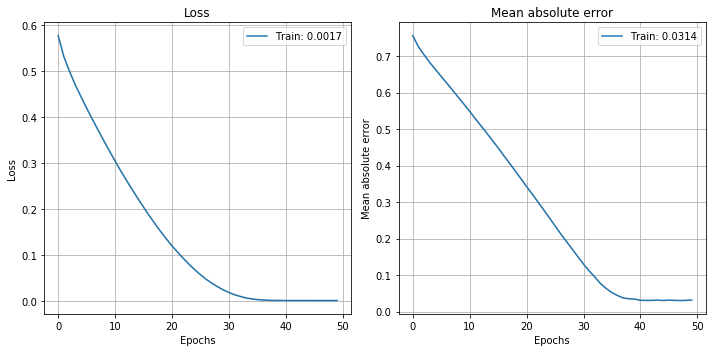

In [36]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_tokyo = model.predict(X_test)

In [37]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(tokyo.iloc[3:105,0])

In [38]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(tokyo.iloc[105:,0])

In [39]:
P_tokyo = scaler1.inverse_transform(P_tokyo)
P_tokyo = pd.DataFrame(P_tokyo)
P_tokyo.index=pd.to_datetime(tokyo.iloc[105:,0])

In [40]:
P_tokyo.index = TimeIndex2
Y_test.index = TimeIndex2
T_tokyo = Y_test

# 愛知

In [41]:
L = len(aichi)
Y = aichi.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [42]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [43]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [44]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [45]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [46]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [47]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.6644 - mean_absolute_error: 0.8115
Epoch 2/50
 - 0s - loss: 0.5913 - mean_absolute_error: 0.7651
Epoch 3/50
 - 0s - loss: 0.5430 - mean_absolute_error: 0.7331
Epoch 4/50
 - 0s - loss: 0.5022 - mean_absolute_error: 0.7050
Epoch 5/50
 - 0s - loss: 0.4655 - mean_absolute_error: 0.6786
Epoch 6/50
 - 0s - loss: 0.4312 - mean_absolute_error: 0.6529
Epoch 7/50
 - 0s - loss: 0.4000 - mean_absolute_error: 0.6286
Epoch 8/50
 - 0s - loss: 0.3704 - mean_absolute_error: 0.6048
Epoch 9/50
 - 0s - loss: 0.3419 - mean_absolute_error: 0.5808
Epoch 10/50
 - 0s - loss: 0.3153 - mean_absolute_error: 0.5577
Epoch 11/50
 - 0s - loss: 0.2894 - mean_absolute_error: 0.5341
Epoch 12/50
 - 0s - loss: 0.2649 - mean_absolute_error: 0.5107
Epoch 13/50
 - 0s - loss: 0.2418 - mean_absolute_error: 0.4877
Epoch 14/50
 - 0s - loss: 0.2199 - mean_absolute_error: 0.4648
Epoch 15/50
 - 0s - loss: 0.1995 - mean_absolute_error: 0.4425
Epoch 16/50
 - 0s - loss: 0.1795 - mean_absolute_error: 0.4194
E

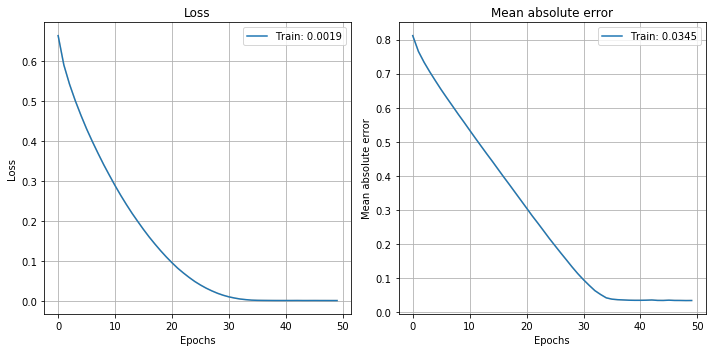

In [48]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_aichi = model.predict(X_test)

In [49]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(aichi.iloc[3:105,0])

In [50]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(aichi.iloc[105:,0])

In [51]:
P_aichi = scaler1.inverse_transform(P_aichi)
P_aichi = pd.DataFrame(P_aichi)
P_aichi.index=pd.to_datetime(aichi.iloc[105:,0])

In [52]:
P_aichi.index = TimeIndex2
Y_test.index = TimeIndex2
T_aichi = Y_test

# 埼玉

In [53]:
L = len(saitama)
Y = saitama.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [54]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [55]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [56]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [57]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [58]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [59]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.7522 - mean_absolute_error: 0.8652
Epoch 2/50
 - 0s - loss: 0.6939 - mean_absolute_error: 0.8309
Epoch 3/50
 - 0s - loss: 0.6544 - mean_absolute_error: 0.8068
Epoch 4/50
 - 0s - loss: 0.6199 - mean_absolute_error: 0.7853
Epoch 5/50
 - 0s - loss: 0.5878 - mean_absolute_error: 0.7646
Epoch 6/50
 - 0s - loss: 0.5574 - mean_absolute_error: 0.7445
Epoch 7/50
 - 0s - loss: 0.5282 - mean_absolute_error: 0.7247
Epoch 8/50
 - 0s - loss: 0.4997 - mean_absolute_error: 0.7049
Epoch 9/50
 - 0s - loss: 0.4724 - mean_absolute_error: 0.6853
Epoch 10/50
 - 0s - loss: 0.4454 - mean_absolute_error: 0.6653
Epoch 11/50
 - 0s - loss: 0.4193 - mean_absolute_error: 0.6455
Epoch 12/50
 - 0s - loss: 0.3940 - mean_absolute_error: 0.6257
Epoch 13/50
 - 0s - loss: 0.3691 - mean_absolute_error: 0.6054
Epoch 14/50
 - 0s - loss: 0.3451 - mean_absolute_error: 0.5854
Epoch 15/50
 - 0s - loss: 0.3219 - mean_absolute_error: 0.5653
Epoch 16/50
 - 0s - loss: 0.2990 - mean_absolute_error: 0.5448
E

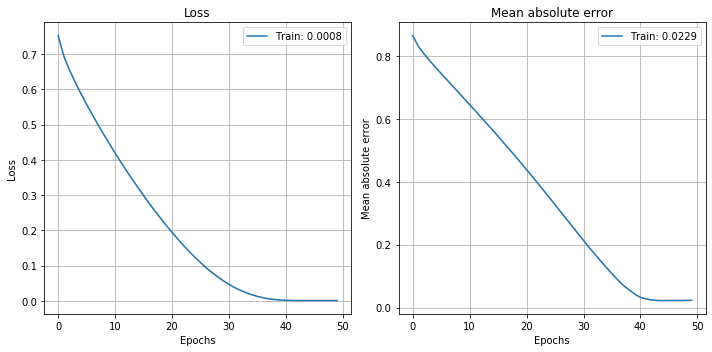

In [60]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_saitama = model.predict(X_test)

In [61]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(saitama.iloc[3:105,0])

In [62]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(saitama.iloc[105:,0])

In [63]:
P_saitama = scaler1.inverse_transform(P_saitama)
P_saitama = pd.DataFrame(P_saitama)
P_saitama.index=pd.to_datetime(saitama.iloc[105:,0])

In [64]:
P_saitama.index = TimeIndex2
Y_test.index = TimeIndex2
T_saitama = Y_test

# 福岡

In [65]:
L = len(hukuoka)
Y = hukuoka.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [66]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [67]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [68]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [69]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [70]:
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]

In [71]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 1.0143 - mean_absolute_error: 1.0047
Epoch 2/50
 - 0s - loss: 0.9273 - mean_absolute_error: 0.9607
Epoch 3/50
 - 0s - loss: 0.8675 - mean_absolute_error: 0.9292
Epoch 4/50
 - 0s - loss: 0.8181 - mean_absolute_error: 0.9023
Epoch 5/50
 - 0s - loss: 0.7738 - mean_absolute_error: 0.8775
Epoch 6/50
 - 0s - loss: 0.7329 - mean_absolute_error: 0.8540
Epoch 7/50
 - 0s - loss: 0.6942 - mean_absolute_error: 0.8311
Epoch 8/50
 - 0s - loss: 0.6564 - mean_absolute_error: 0.8080
Epoch 9/50
 - 0s - loss: 0.6205 - mean_absolute_error: 0.7856
Epoch 10/50
 - 0s - loss: 0.5860 - mean_absolute_error: 0.7634
Epoch 11/50
 - 0s - loss: 0.5524 - mean_absolute_error: 0.7411
Epoch 12/50
 - 0s - loss: 0.5194 - mean_absolute_error: 0.7185
Epoch 13/50
 - 0s - loss: 0.4875 - mean_absolute_error: 0.6961
Epoch 14/50
 - 0s - loss: 0.4563 - mean_absolute_error: 0.6734
Epoch 15/50
 - 0s - loss: 0.4259 - mean_absolute_error: 0.6504
Epoch 16/50
 - 0s - loss: 0.3966 - mean_absolute_error: 0.6276
E

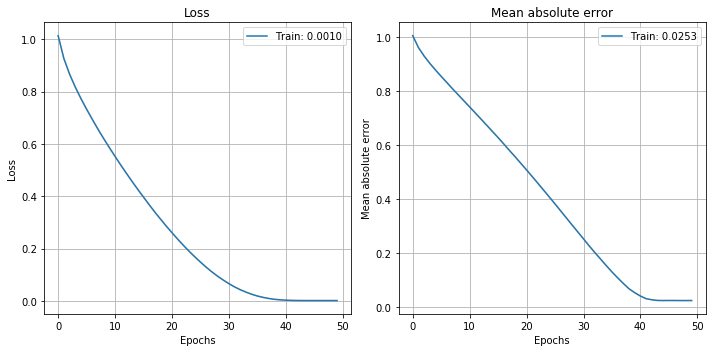

In [72]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_hukuoka = model.predict(X_test)

In [73]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(hukuoka.iloc[3:105,0])

In [74]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(hukuoka.iloc[105:,0])

In [75]:
P_hukuoka = scaler1.inverse_transform(P_hukuoka)
P_hukuoka = pd.DataFrame(P_hukuoka)
P_hukuoka.index=pd.to_datetime(hukuoka.iloc[105:,0])

In [76]:
P_hukuoka.index = TimeIndex2
Y_test.index = TimeIndex2
T_hukuoka = Y_test

# plot

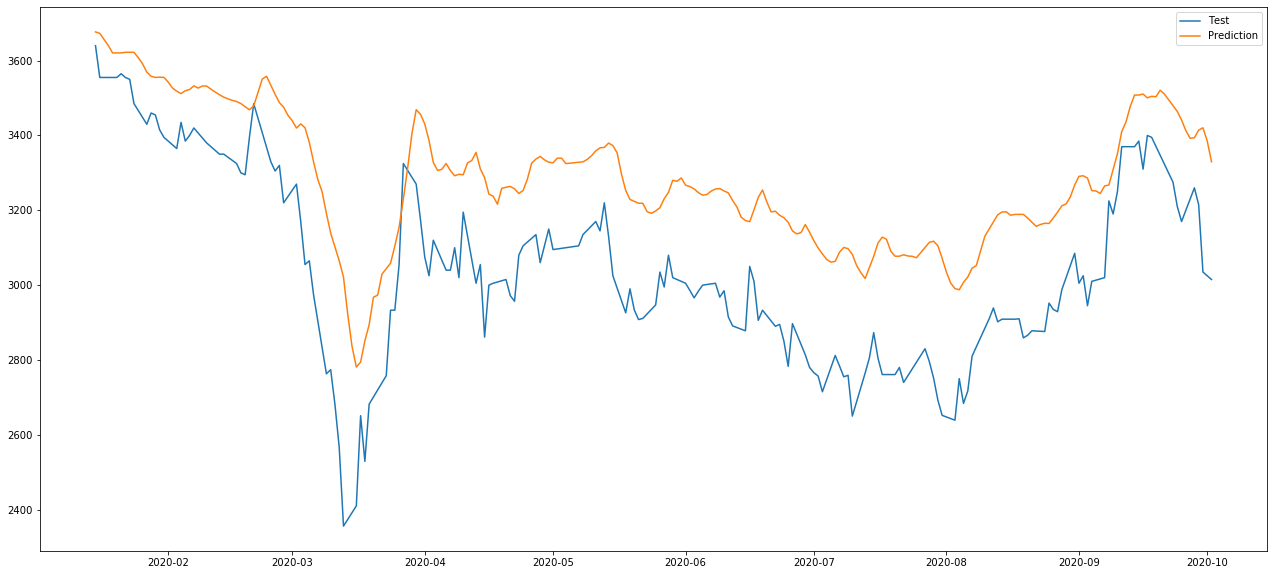

In [77]:
plt.figure(figsize=(22,10))
plt.plot(T_aichi, label = 'Test')
plt.plot(P_aichi, label = 'Prediction')
plt.legend(loc='best')
plt.show()

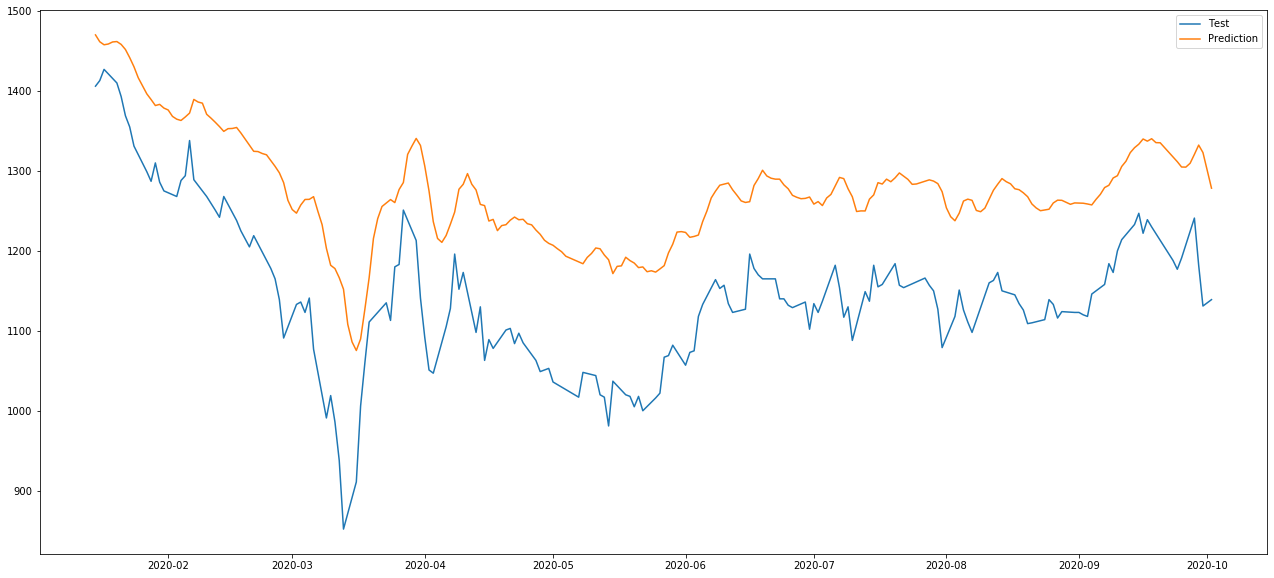

In [78]:
plt.figure(figsize=(22,10))
plt.plot(T_tokyo, label = 'Test')
plt.plot(P_tokyo, label = 'Prediction')
plt.legend(loc='best')
plt.show()

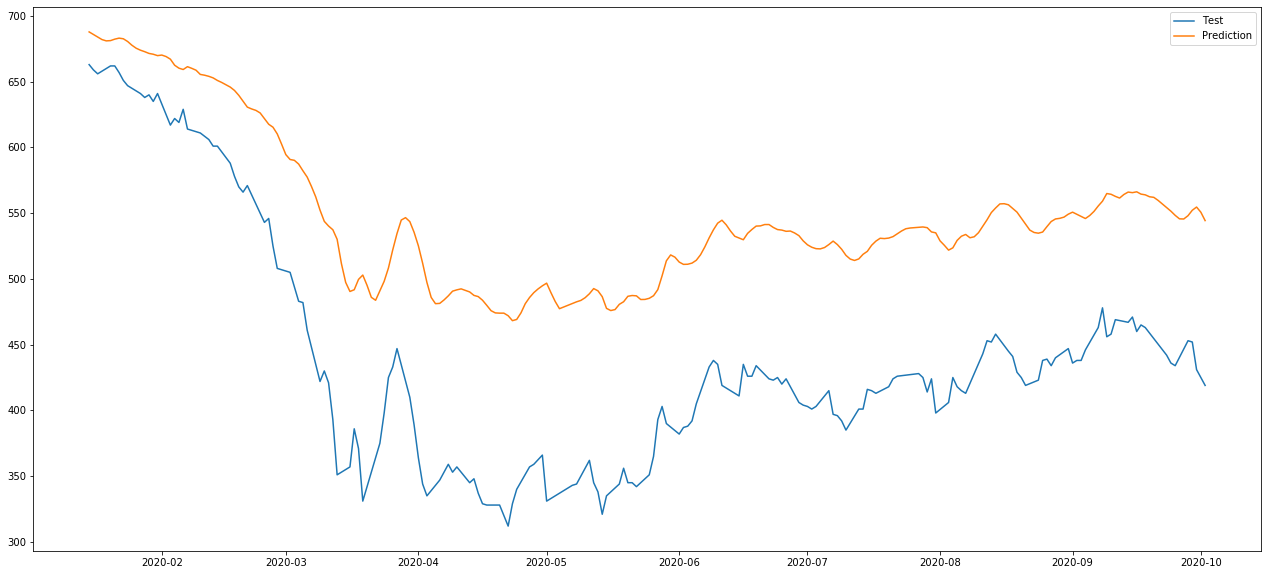

In [79]:
plt.figure(figsize=(22,10))
plt.plot(T_oosaka, label = 'Test')
plt.plot(P_oosaka, label = 'Prediction')
plt.legend(loc='best')
plt.show()

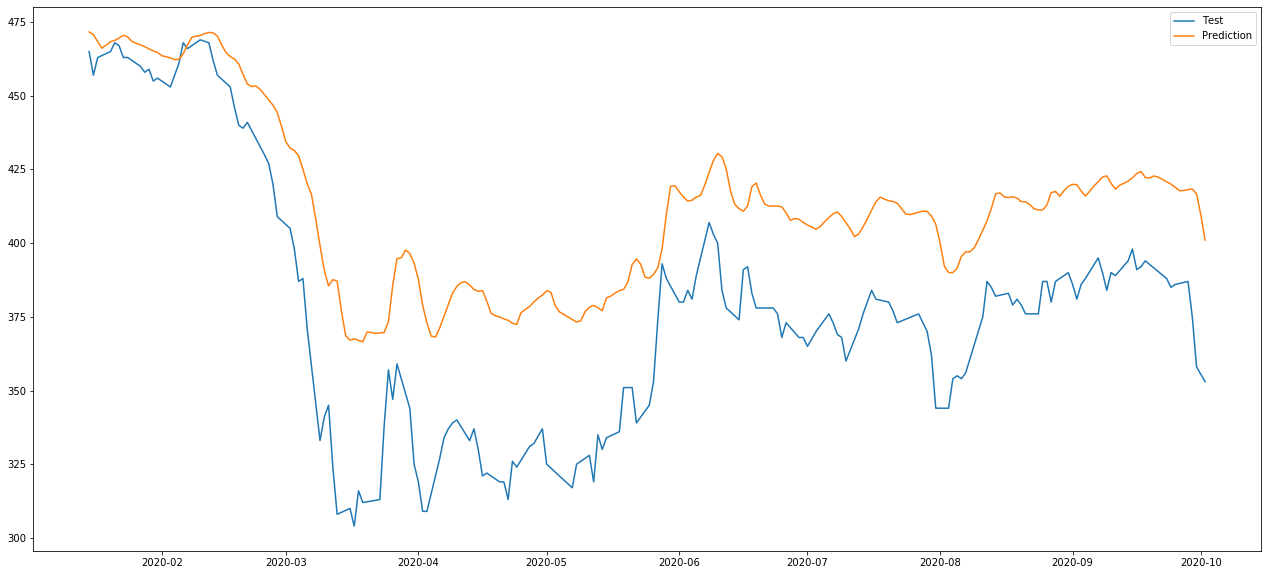

In [80]:
plt.figure(figsize=(22,10))
plt.plot(T_saitama, label = 'Test')
plt.plot(P_saitama, label = 'Prediction')
plt.legend(loc='best')
plt.show()

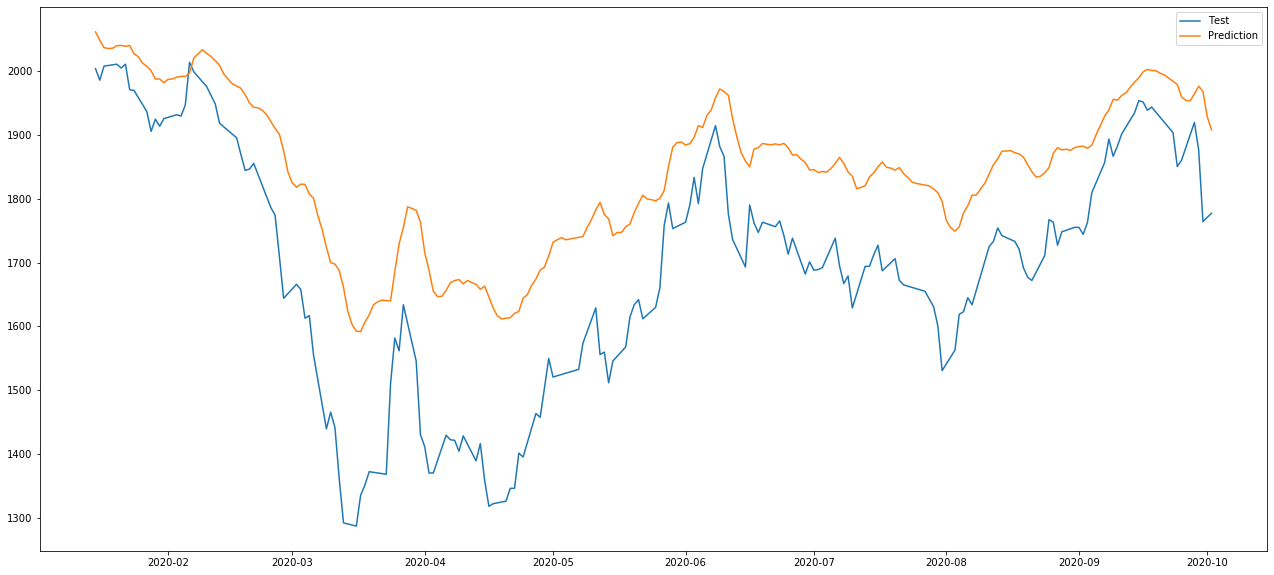

In [81]:
plt.figure(figsize=(22,10))
plt.plot(T_hukuoka, label = 'Test')
plt.plot(P_hukuoka, label = 'Prediction')
plt.legend(loc='best')
plt.show()

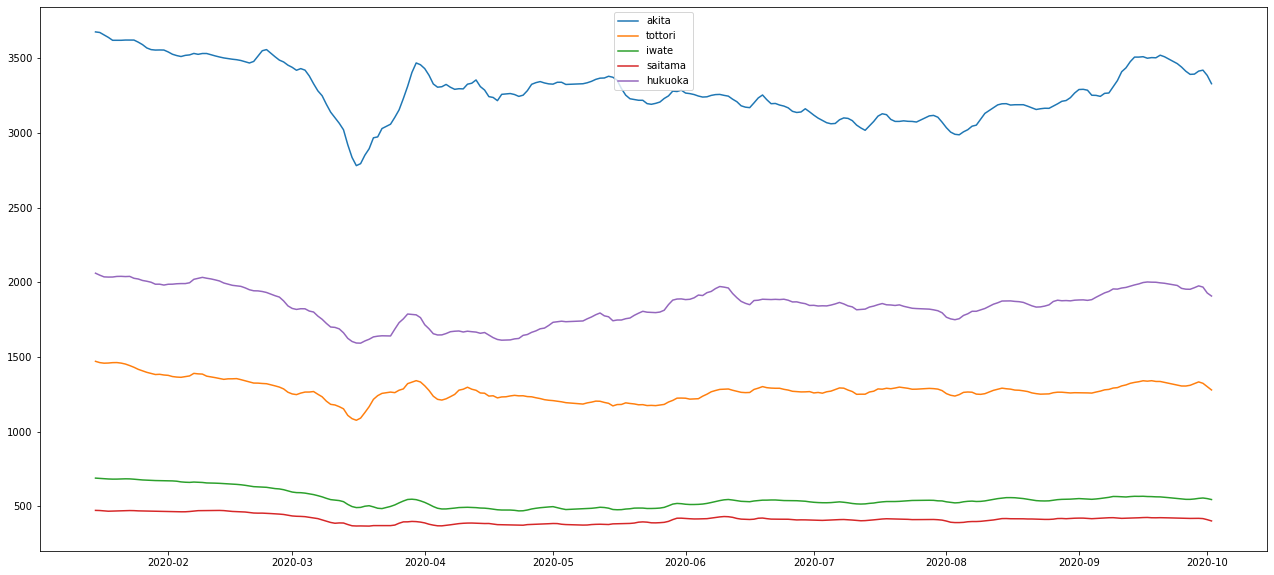

In [82]:
plt.figure(figsize=(22,10))
plt.plot(P_aichi, label = 'akita')
plt.plot(P_tokyo, label = 'tottori')
plt.plot(P_oosaka, label = 'iwate')
plt.plot(P_saitama, label = 'saitama')
plt.plot(P_hukuoka, label = 'hukuoka')
plt.legend(loc='best')
plt.show()

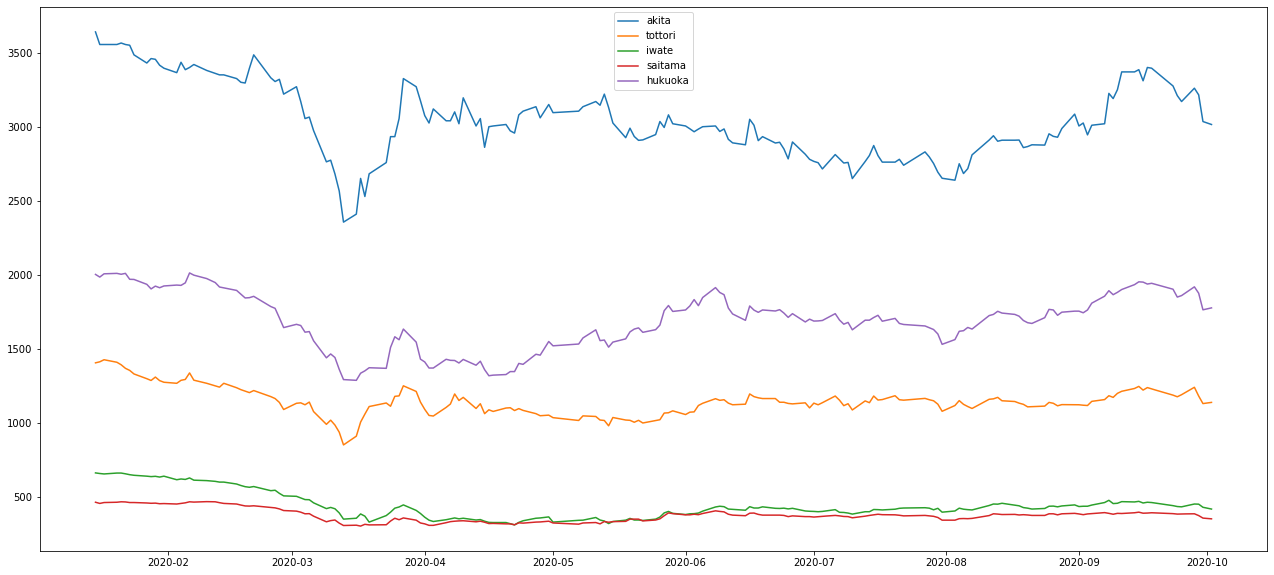

In [83]:
plt.figure(figsize=(22,10))
plt.plot(T_aichi, label = 'akita')
plt.plot(T_tokyo, label = 'tottori')
plt.plot(T_oosaka, label = 'iwate')
plt.plot(T_saitama, label = 'saitama')
plt.plot(T_hukuoka, label = 'hukuoka')
plt.legend(loc='best')
plt.show()

In [84]:
P_aichi['diff']=P_aichi.diff()
P_tokyo['diff']=P_tokyo.diff()
P_oosaka['diff']=P_oosaka.diff()
P_saitama['diff']=P_saitama.diff()
P_hukuoka['diff']=P_hukuoka.diff()

In [85]:
T_aichi['diff'] = T_aichi.diff()
T_tokyo['diff'] = T_tokyo.diff()
T_oosaka['diff'] = T_oosaka.diff()
T_saitama['diff'] = T_saitama.diff()
T_hukuoka['diff'] = T_hukuoka.diff()

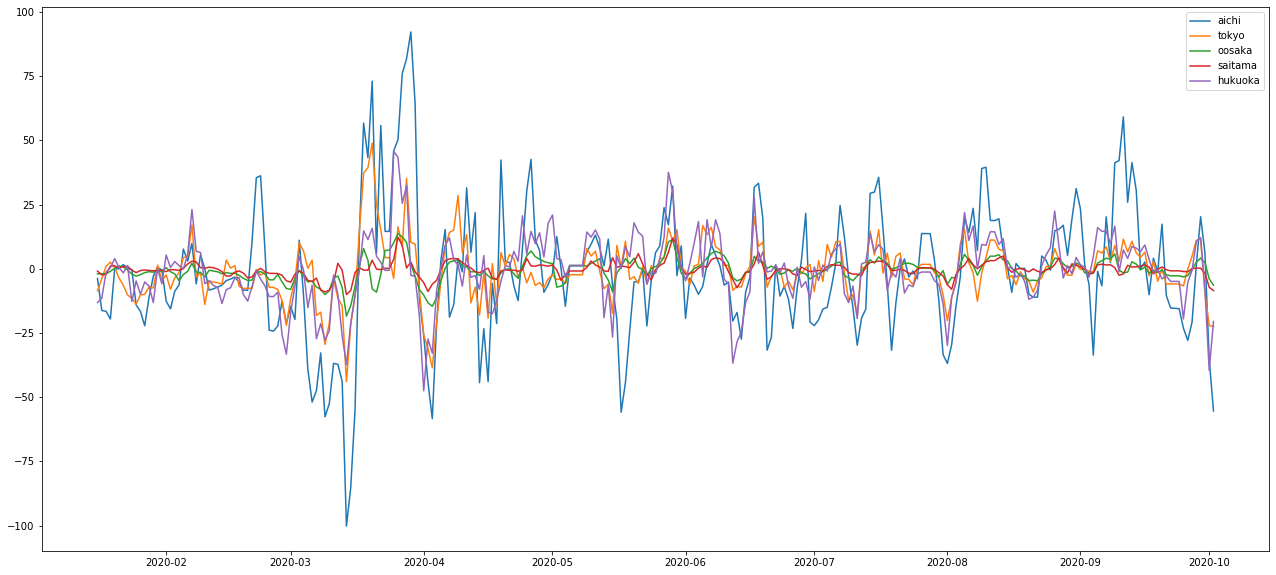

In [86]:
plt.figure(figsize=(22,10))
plt.plot(P_aichi['diff'], label = 'aichi')
plt.plot(P_tokyo['diff'], label = 'tokyo')
plt.plot(P_oosaka['diff'], label = 'oosaka')
plt.plot(P_saitama['diff'], label = 'saitama')
plt.plot(P_hukuoka['diff'], label = 'hukuoka')
plt.savefig('P_best5.png')
plt.legend(loc='best')
plt.show()

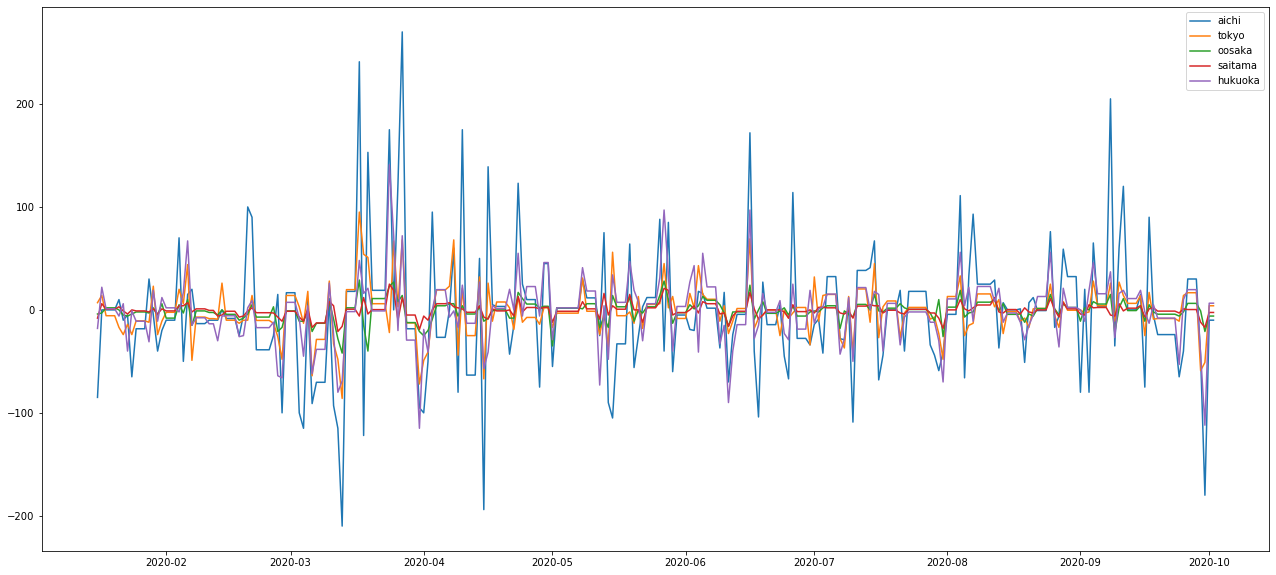

In [87]:
plt.figure(figsize=(22,10))
plt.plot(T_aichi['diff'], label = 'aichi')
plt.plot(T_tokyo['diff'], label = 'tokyo')
plt.plot(T_oosaka['diff'], label = 'oosaka')
plt.plot(T_saitama['diff'], label = 'saitama')
plt.plot(T_hukuoka['diff'], label = 'hukuoka')
plt.savefig('best5.png')
plt.legend(loc='best')
plt.show()

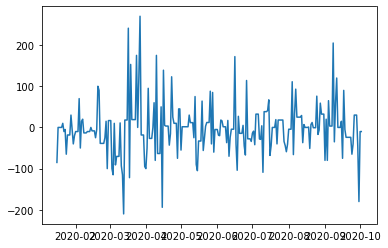

In [88]:
plt.plot(T_aichi['diff'], label = 'aichi')
plt.savefig('aichi.png')

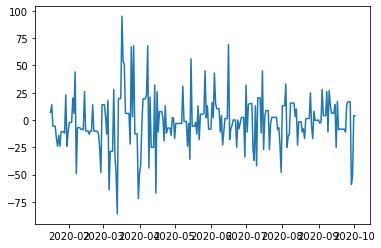

In [89]:
plt.plot(T_tokyo['diff'], label = 'tokyo')
plt.savefig('tokyo.png')

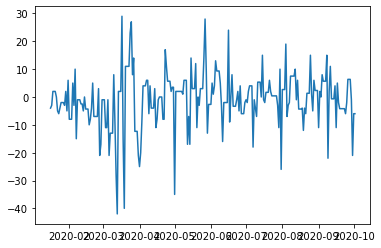

In [90]:
plt.plot(T_oosaka['diff'], label = 'oosaka')
plt.savefig('oosaka.png')

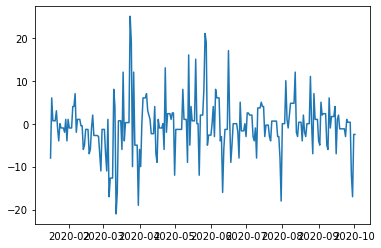

In [91]:
plt.plot(T_saitama['diff'], label = 'saitama')
plt.savefig('saitama.png')

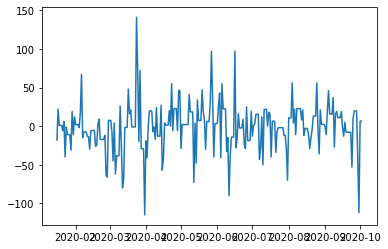

In [92]:
plt.plot(T_hukuoka['diff'], label = 'hukuoka')
plt.savefig('hukuoka.png')

Epoch 1/50
 - 0s - loss: 0.3767 - mean_absolute_error: 0.6024
Epoch 2/50
 - 0s - loss: 0.3309 - mean_absolute_error: 0.5639
Epoch 3/50
 - 0s - loss: 0.3006 - mean_absolute_error: 0.5371
Epoch 4/50
 - 0s - loss: 0.2748 - mean_absolute_error: 0.5131
Epoch 5/50
 - 0s - loss: 0.2501 - mean_absolute_error: 0.4888
Epoch 6/50
 - 0s - loss: 0.2281 - mean_absolute_error: 0.4665
Epoch 7/50
 - 0s - loss: 0.2076 - mean_absolute_error: 0.4446
Epoch 8/50
 - 0s - loss: 0.1878 - mean_absolute_error: 0.4223
Epoch 9/50
 - 0s - loss: 0.1686 - mean_absolute_error: 0.3995
Epoch 10/50
 - 0s - loss: 0.1515 - mean_absolute_error: 0.3782
Epoch 11/50
 - 0s - loss: 0.1341 - mean_absolute_error: 0.3549
Epoch 12/50
 - 0s - loss: 0.1185 - mean_absolute_error: 0.3331
Epoch 13/50
 - 0s - loss: 0.1032 - mean_absolute_error: 0.3100
Epoch 14/50
 - 0s - loss: 0.0892 - mean_absolute_error: 0.2874
Epoch 15/50
 - 0s - loss: 0.0762 - mean_absolute_error: 0.2646
Epoch 16/50
 - 0s - loss: 0.0644 - mean_absolute_error: 0.2418
E

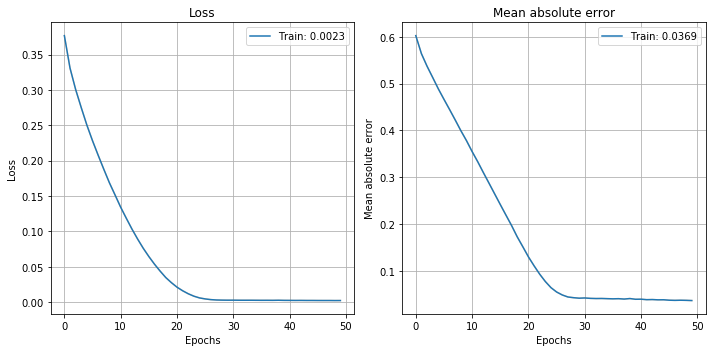

In [93]:
iwate = pd.read_csv('program/Stock2/stock2.csv', encoding="shift_jis")
iwate['day'] = pd.to_datetime(iwate['day'], format='%Y/%m/%d')
iwate.set_index('day')
dateTimeIndex = pd.DatetimeIndex(iwate['day'])
iwate.index = dateTimeIndex
iwate = iwate['2019-10-02':'2020-10-02']
iwate = iwate.resample('D').interpolate()
iwate.drop("day", axis=1)
L = len(iwate)
Y = iwate.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。
# train, testデータを定義
X_train = X[:102, :, :]
X_test = X[102:, :, :]
Y_train = Y[:102, :]
Y_test = Y[102:, :]
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_iwate = model.predict(X_test)
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(iwate.iloc[3:105,0])
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(iwate.iloc[105:,0])
P_iwate = scaler1.inverse_transform(P_iwate)
P_iwate = pd.DataFrame(P_iwate)
P_iwate.index=pd.to_datetime(iwate.iloc[105:,0])
P_iwate.index = TimeIndex2
Y_test.index = TimeIndex2
T_iwate = Y_test
P_iwate['diff']=P_iwate.diff()
T_iwate['diff'] = T_iwate.diff()


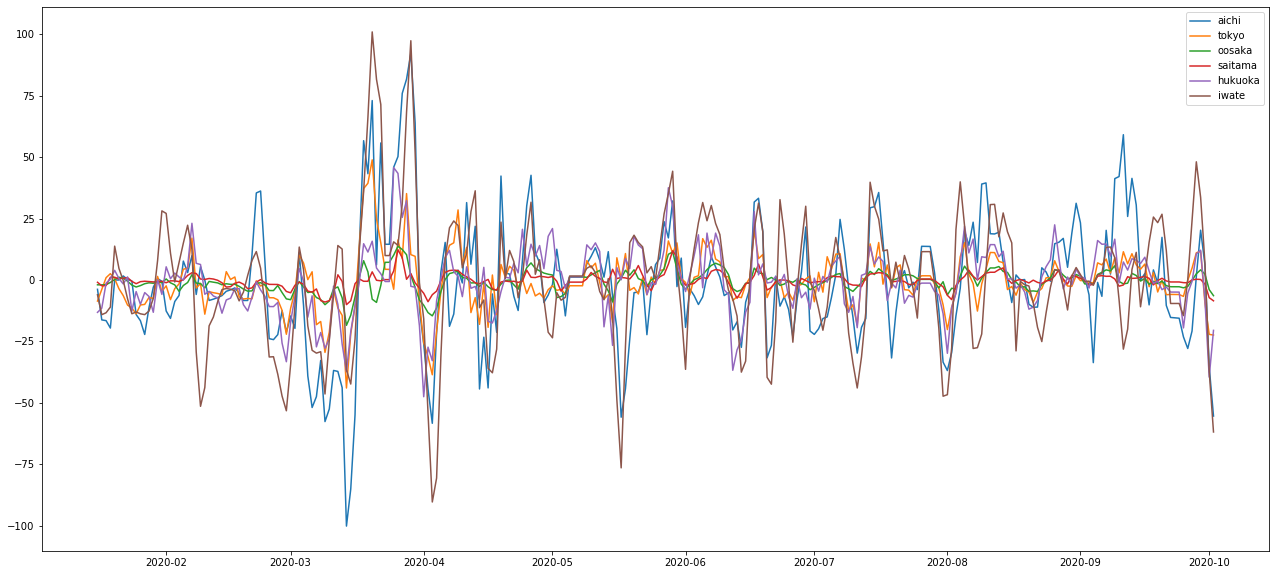

In [94]:
plt.figure(figsize=(22,10))
plt.plot(P_aichi['diff'], label = 'aichi')
plt.plot(P_tokyo['diff'], label = 'tokyo')
plt.plot(P_oosaka['diff'], label = 'oosaka')
plt.plot(P_saitama['diff'], label = 'saitama')
plt.plot(P_hukuoka['diff'], label = 'hukuoka')
plt.plot(P_iwate['diff'], label = 'iwate')
plt.savefig('P_best5.png')
plt.legend(loc='best')
plt.show()

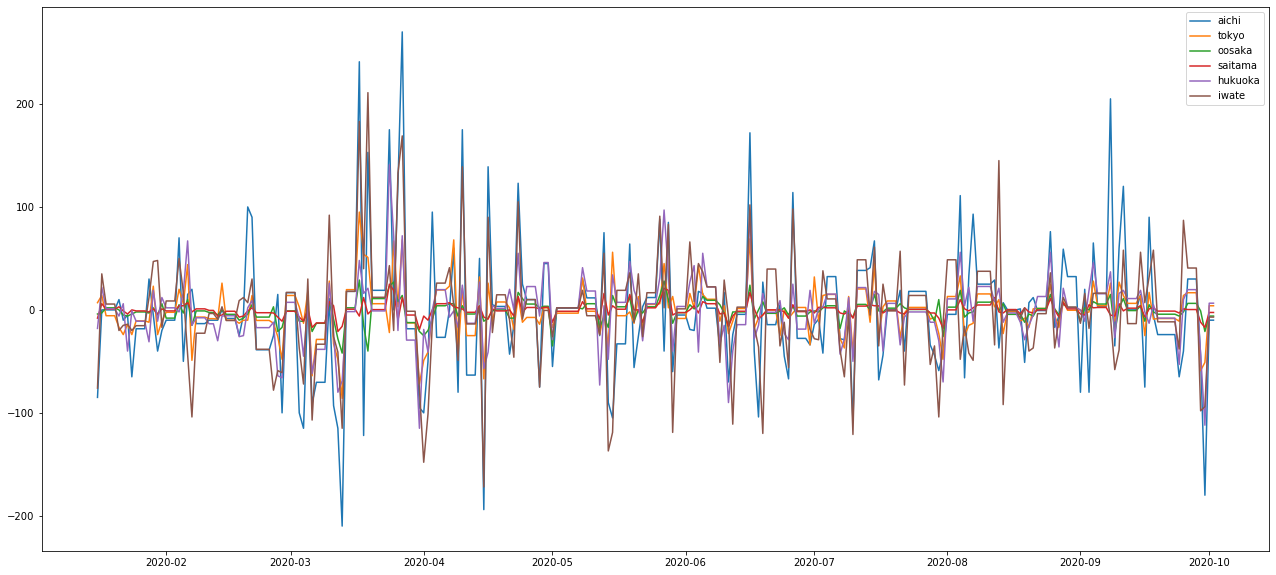

In [95]:
plt.figure(figsize=(22,10))
plt.plot(T_aichi['diff'], label = 'aichi')
plt.plot(T_tokyo['diff'], label = 'tokyo')
plt.plot(T_oosaka['diff'], label = 'oosaka')
plt.plot(T_saitama['diff'], label = 'saitama')
plt.plot(T_hukuoka['diff'], label = 'hukuoka')
plt.plot(T_iwate['diff'], label = 'iwate')
plt.savefig('best5.png')
plt.legend(loc='best')
plt.show()

# covid

In [96]:
data=pd.read_csv("program/covid19_pref_20200421.csv")

In [97]:
tokyo = data['東京都']
dateTimeIndex = pd.DatetimeIndex(data['date'])
tokyo.index = dateTimeIndex
#plt.plot(tokyo, label = 'tokyo')
#plt.plot(T_tokyo['diff'], label = 'tokyo')
#plt.legend(loc='best')
#plt.show()

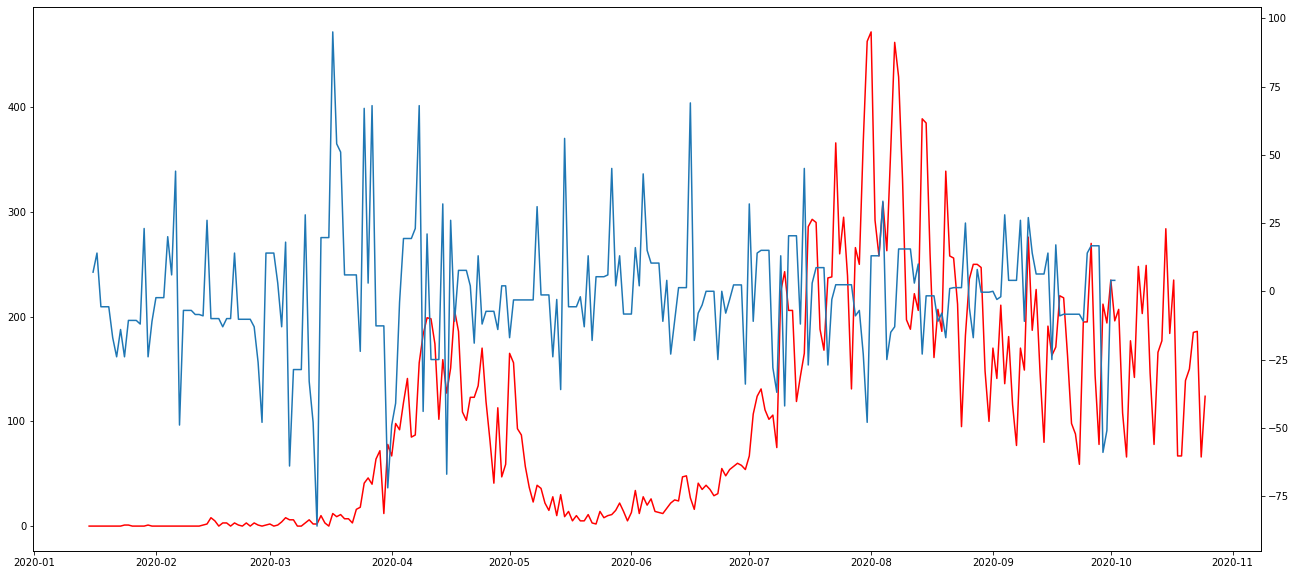

In [98]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(tokyo, label = 'tokyo',color = 'r')
ln2=ax2.plot(T_tokyo['diff'], label = 'tokyo')
plt.savefig('C-T tokyo.png')

In [99]:
oosaka = data['大阪府']
dateTimeIndex = pd.DatetimeIndex(data['date'])
oosaka.index = dateTimeIndex
#plt.plot(oosaka, label = 'oosaka')
#plt.legend(loc='best')
#plt.show()

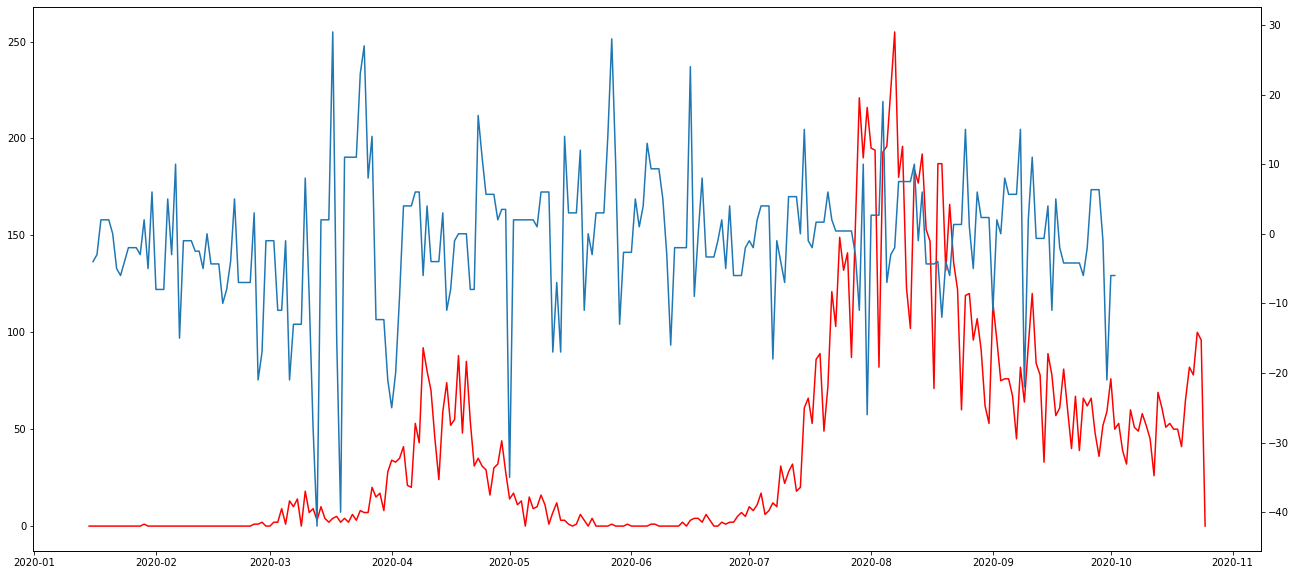

In [100]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(oosaka, label = 'oosaka',color = 'r')
ln2=ax2.plot(T_oosaka['diff'], label = 'oosaka')
plt.savefig('C-T oosaka.png')

In [101]:
aichi = data['愛知県']
dateTimeIndex = pd.DatetimeIndex(data['date'])
aichi.index = dateTimeIndex
#plt.plot(aichi, label = 'aichi')
#plt.legend(loc='best')
#plt.show()

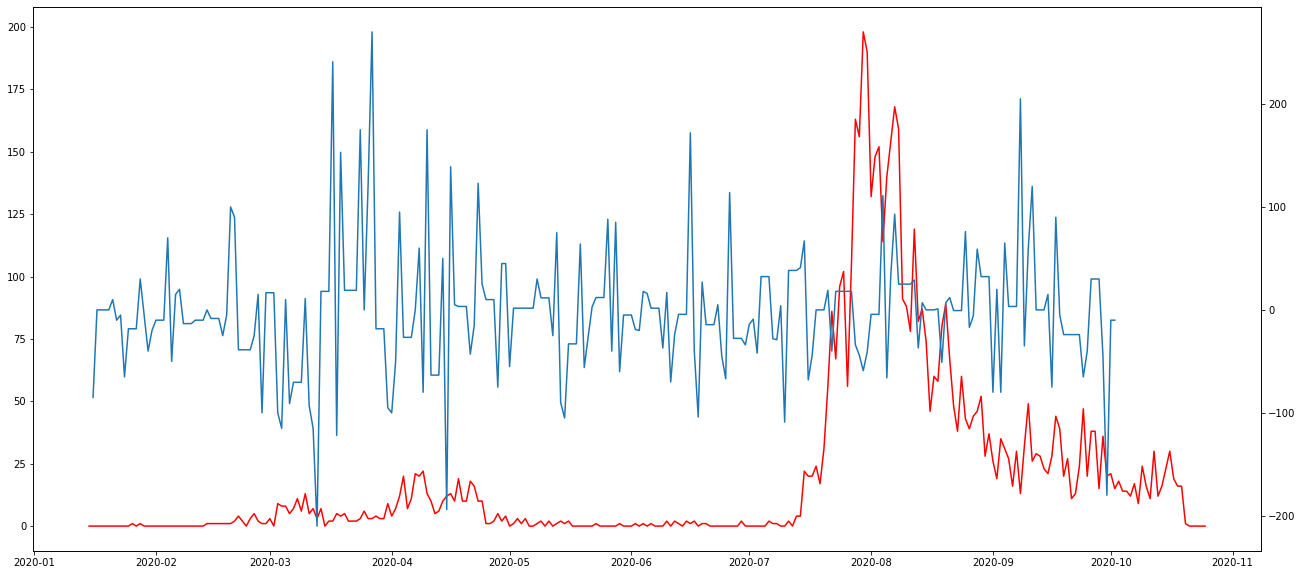

In [102]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(aichi, label = 'aichi',color = 'r')
ln2=ax2.plot(T_aichi['diff'], label = 'aichi')
plt.savefig('C-T aichi.png')

In [103]:
saitama = data['埼玉県']
dateTimeIndex = pd.DatetimeIndex(data['date'])
saitama.index = dateTimeIndex
#plt.plot(saitama, label = 'saitama')
#plt.legend(loc='best')
#plt.show()

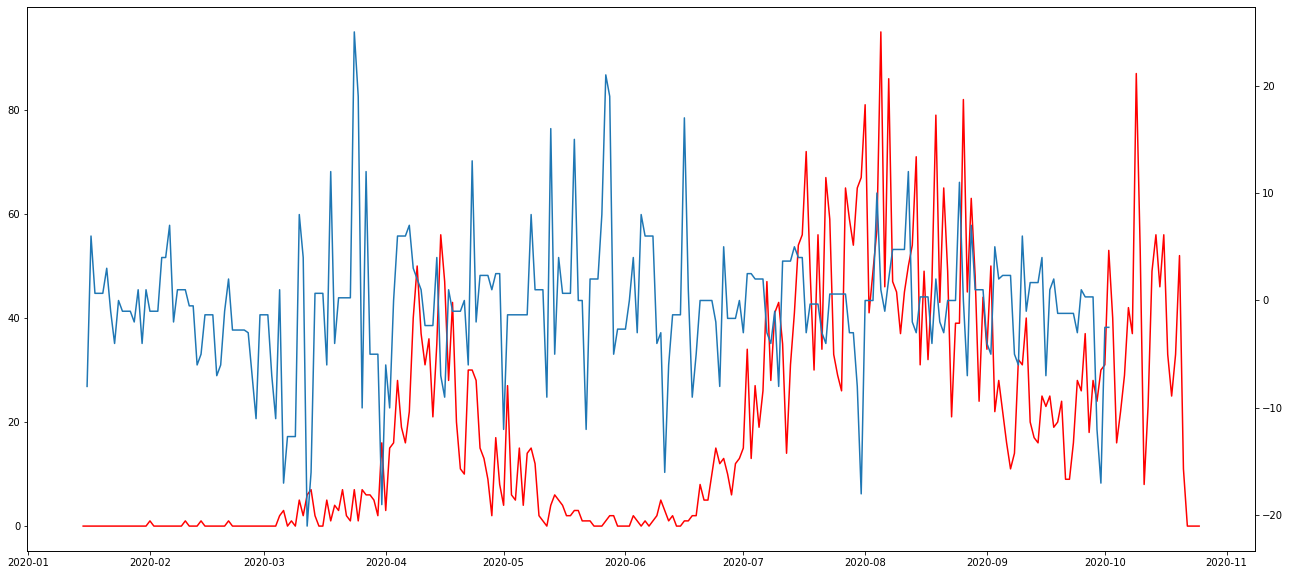

In [104]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(saitama, label = 'saitama',color = 'r')
ln2=ax2.plot(T_saitama['diff'], label = 'saitama')
plt.savefig('C-T saitama.png')

In [105]:
hukuoka = data['福岡県']
dateTimeIndex = pd.DatetimeIndex(data['date'])
hukuoka.index = dateTimeIndex
#plt.plot(hukuoka, label = 'hukuoka')
#plt.legend(loc='best')
#plt.show()

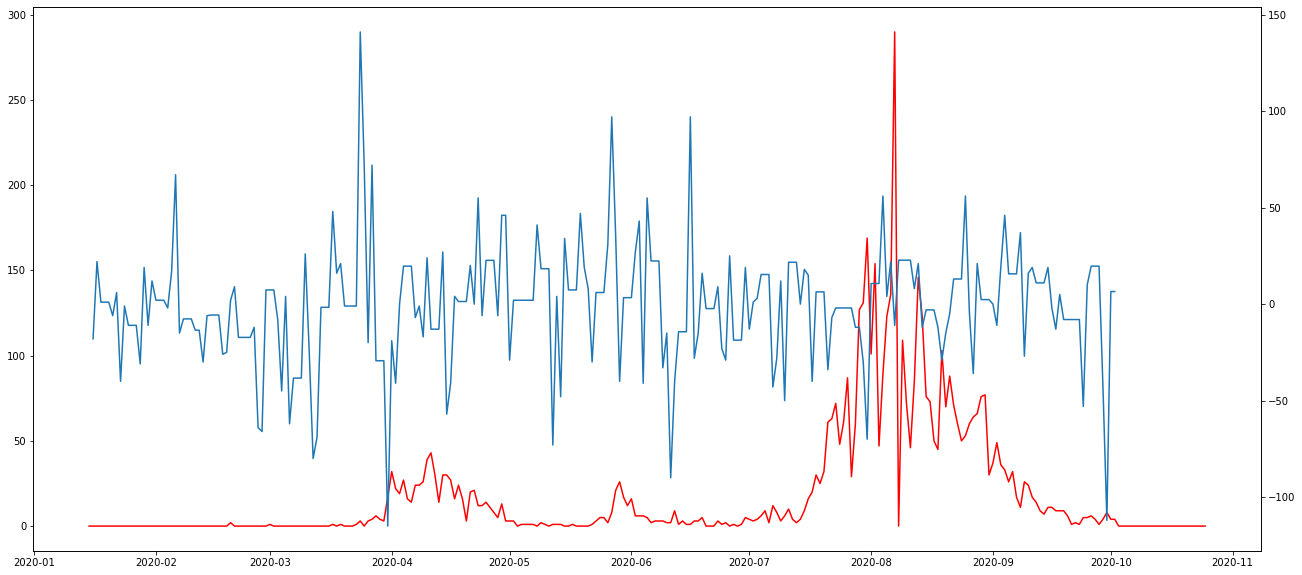

In [106]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(hukuoka, label = 'hukuoka',color = 'r')
ln2=ax2.plot(T_hukuoka['diff'], label = 'hukuoka')
plt.savefig('C-T hukuoka.png')

In [107]:
s_tokyo = (S_tokyo['指数移動平均(30)'])
s_tokyo.index = TimeIndex
s_tokyo = s_tokyo.replace(np.nan, '0')
s_tokyo  = s_tokyo.astype(float)
s_tokyo = s_tokyo['2020-01-14':'2020-10-02']

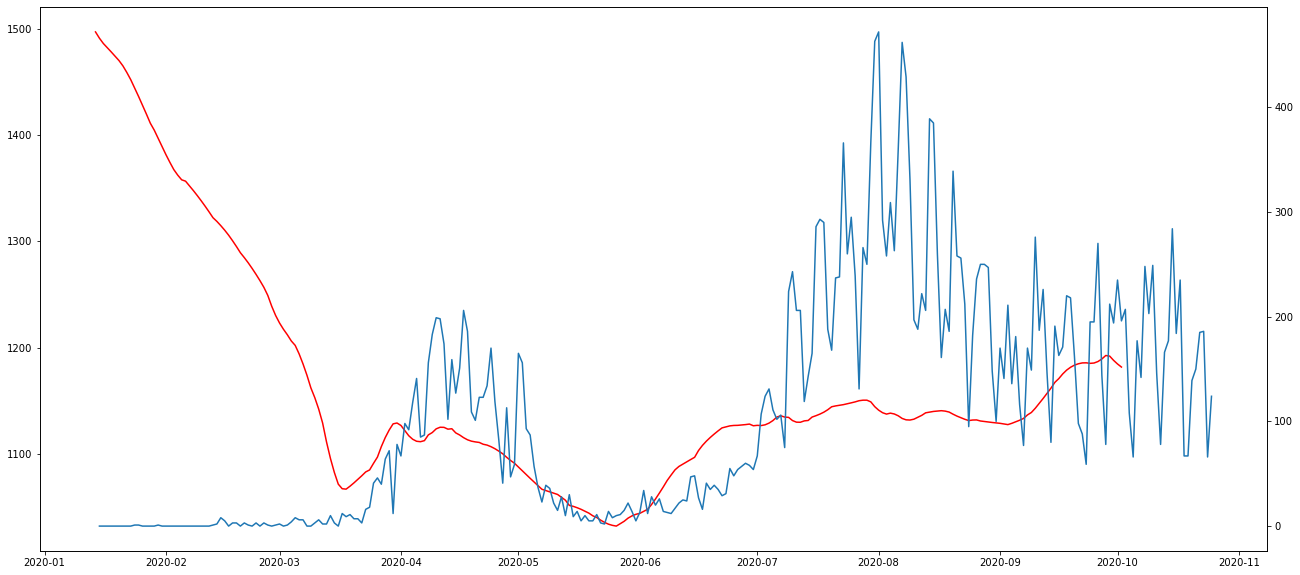

In [108]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_tokyo, label = 's-tokyo',color = 'r')
ln2=ax2.plot(tokyo, label = 'C-tokyo')
plt.savefig('C-S tokyo.png')

In [109]:
s_oosaka = (S_oosaka['指数移動平均(30)'])
s_oosaka.index = TimeIndex
s_oosaka = s_oosaka.replace(np.nan, '0')
s_oosaka  = s_oosaka.astype(float)
s_oosaka = s_oosaka['2020-01-14':'2020-10-02']

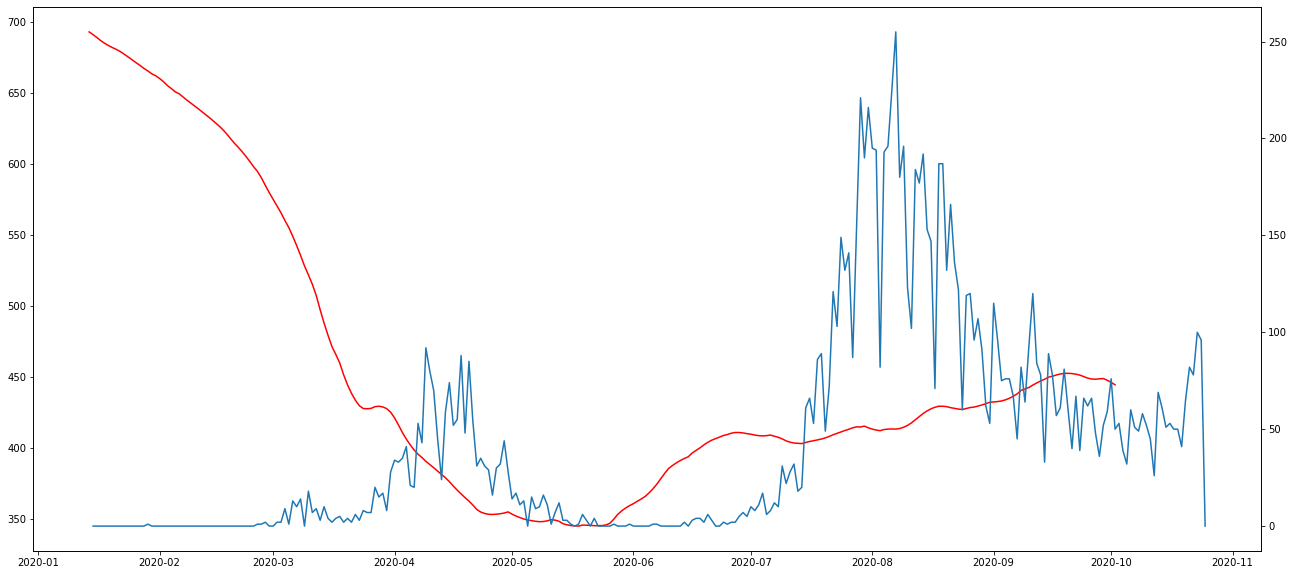

In [110]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_oosaka, label = 's-oosaka',color = 'r')
ln2=ax2.plot(oosaka, label = 'C-oosaka')
plt.savefig('C-S oosaka.png')

In [111]:
s_aichi = (S_aichi['指数移動平均(30)'])
s_aichi.index = TimeIndex
s_aichi = s_aichi.replace(np.nan, '0')
s_aichi  = s_aichi.astype(float)
s_aichi = s_aichi['2020-01-14':'2020-10-02']

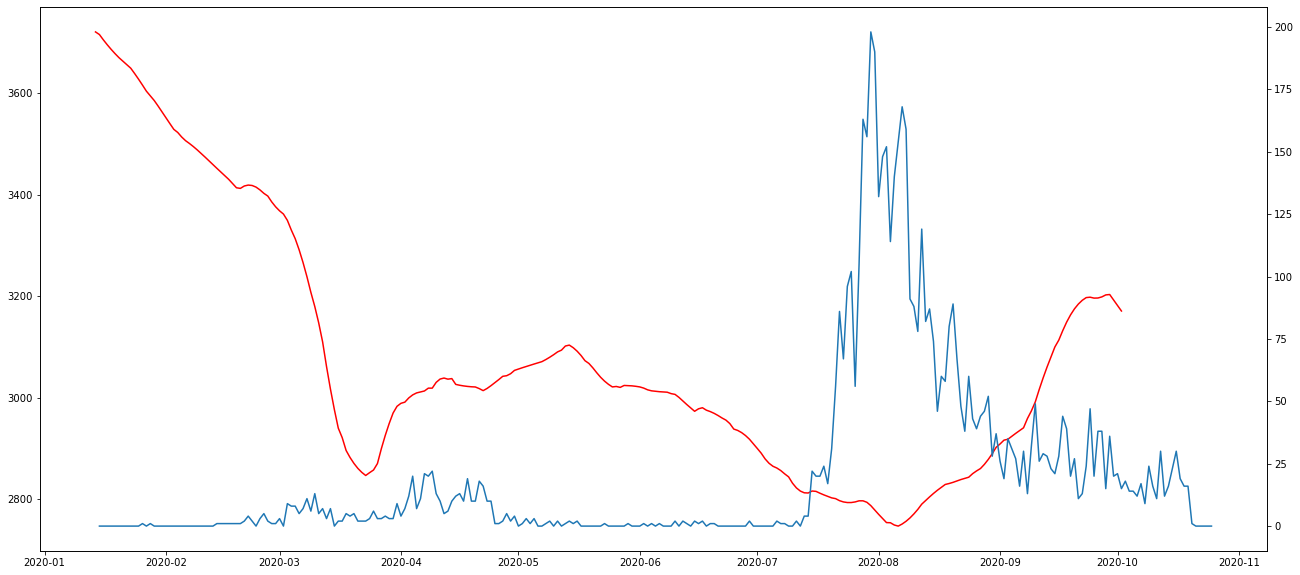

In [112]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_aichi, label = 's-aichi',color = 'r')
ln2=ax2.plot(aichi, label = 'C-aichi')
plt.savefig('C-S aichi.png')

In [113]:
s_saitama = (S_saitama['指数移動平均(30)'])
s_saitama.index = TimeIndex
s_saitama = s_saitama.replace(np.nan, '0')
s_saitama  = s_saitama.astype(float)
s_saitama = s_saitama['2020-01-14':'2020-10-02']

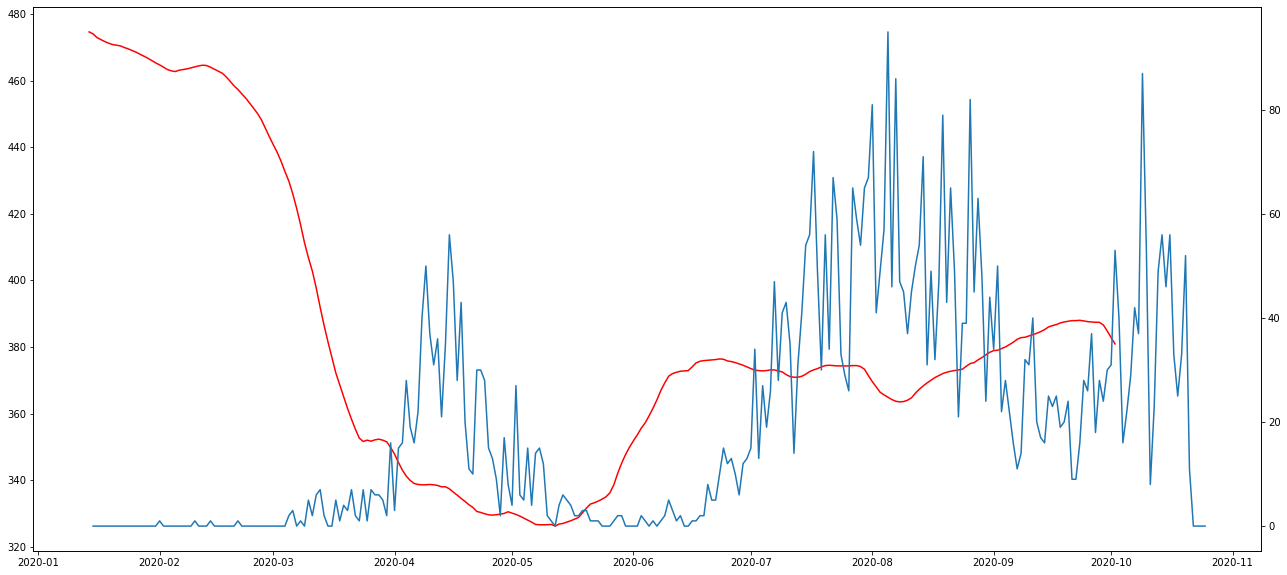

In [114]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_saitama, label = 's-saitama',color = 'r')
ln2=ax2.plot(saitama, label = 'C-saitama')
plt.savefig('C-S saitama.png')

In [115]:
s_hukuoka = (S_hukuoka['指数移動平均(30)'])
s_hukuoka.index = TimeIndex
s_hukuoka = s_hukuoka.replace(np.nan, '0')
s_hukuoka  = s_hukuoka.astype(float)
s_hukuoka = s_hukuoka['2020-01-14':'2020-10-02']

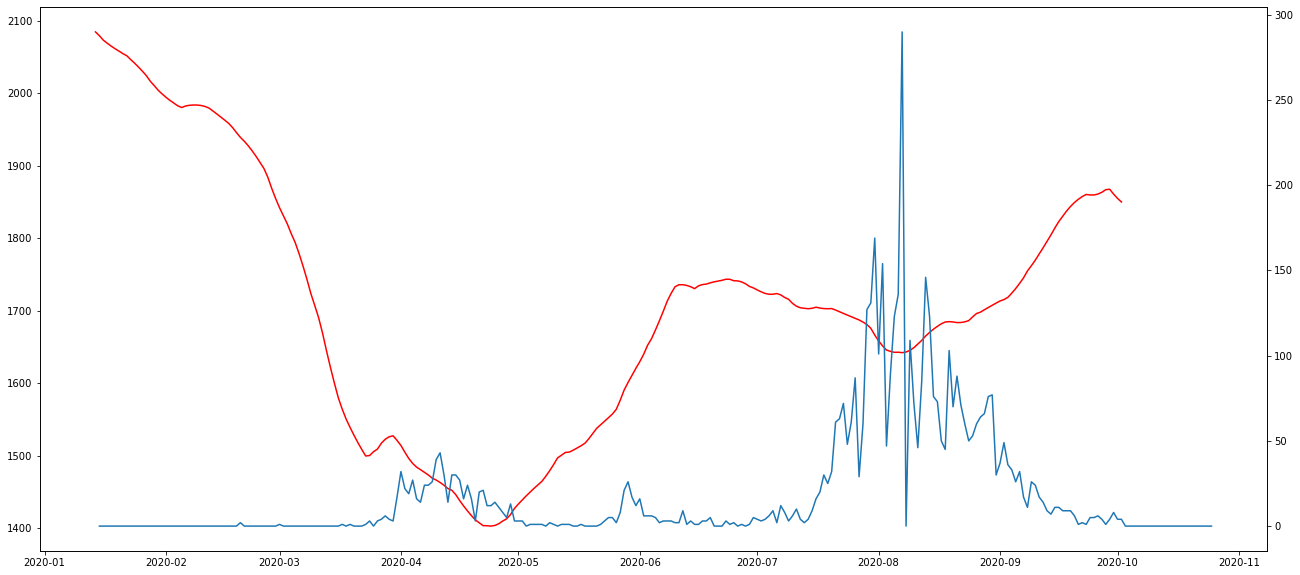

In [116]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ln1=ax1.plot(s_hukuoka, label = 's-hukuoka',color = 'r')
ln2=ax2.plot(hukuoka, label = 'C-hukuoka')
plt.savefig('C-S hukuoka.png')